## News Article Similarity Modelling
- Cross encoding 
- Translated data 
- Using Title 

In [1]:
from tqdm.auto import tqdm
import torch 
import random
from torch import nn
from transformers import RobertaTokenizer, PreTrainedTokenizer, DistilBertTokenizer, DistilBertModel, RobertaModel
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses
from datasets import Dataset
import pandas as pd
from transformers.optimization import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt 
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
from torch.nn import CosineEmbeddingLoss
import transformers
import seaborn as sns
#Build up to SBERT model 

In [2]:
deviceNum = 0
device = torch.device("cuda:" + str(deviceNum) if torch.cuda.is_available() else "cpu")


In [3]:
def check_mem():
    torch.cuda.empty_cache()
    a = torch.cuda.memory_allocated(deviceNum)/1024/1024/1024
    r = torch.cuda.memory_reserved(deviceNum)/1024/1024/1024
    print("torch.cuda.memory_allocated: %fGB"%a)
    print("torch.cuda.memory_reserved: %fGB"%r)
    print("torch.cuda.memory_free: %fGB"%(r-a))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(deviceNum)/1024/1024/1024))
check_mem()

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


In [4]:
#set seeds 
torch.manual_seed(85)
random.seed(85)

In [5]:
df = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/translatedCleaned.tsv", sep="\t")
#df = df.loc[(df["url1_lang"] == "en") & (df["url2_lang"] == "en")]

groundTruths = ["Geography", "Entities","Narrative", "Overall"]
features = ['text1', 'text2', 'title1', 'title2', 'url1_lang', 'url2_lang']
toSelect = groundTruths + features 

#get only the columns we need 
#TODO: do we need "pair_id"? 
leanDf = df[toSelect].dropna()

#rescale data from (0, 4): (0, 1)
for colName in groundTruths: 
    leanDf[colName] = 1 - ((leanDf[colName] - 1) / 3)

#reset index so it is contiguous set of numbers 
leanDf = leanDf.reset_index(drop=True)

#now combine title and text together 
#first add ". " to title 
leanDf["title1"] = leanDf["title1"].apply(lambda x: x + ". ")
leanDf["title2"] = leanDf["title2"].apply(lambda x: x + ". ")

leanDf["text1"] = leanDf["title1"] + leanDf["text1"]
leanDf["text2"] = leanDf["title2"] + leanDf["text2"]


In [6]:
df.columns

Index(['Unnamed: 0', 'url1_lang', 'url2_lang', 'pair_id', 'link1', 'link2',
       'ia_link1', 'ia_link2', 'Geography', 'Entities', 'Time', 'Narrative',
       'Overall', 'Style', 'Tone', 'id1', 'id2', 'ogText1', 'ogTitle1',
       'ogText2', 'ogTitle2', 'text1', 'title1', 'text2', 'title2'],
      dtype='object')

In [7]:
leanDf["url2_lang"].value_counts()

en    2296
de     845
es     560
tr     455
pl     310
ar     268
fr      72
Name: url2_lang, dtype: int64

In [8]:
#NOTE: do a language cutoff 
langList = ["en", "fr", "es"]
leanDf = leanDf[(leanDf["url1_lang"].isin(langList)) & (leanDf["url2_lang"].isin(langList))]

In [9]:
#we only want to sample validation data from the pairs that are both english 
enDf = leanDf[(leanDf["url1_lang"] == "en") & (leanDf["url2_lang"] == "en")]
validProp = .1
validCount = int(validProp * len(enDf))
print(validCount)
validIndices = random.sample(list(enDf.index), validCount)

#get dataframe with indices of only the original english pairs 
validDf = enDf.loc[validIndices]

#train data should be all rows that aren't in the validation set 
#here we are taking a set difference and then indexing what remains 
trainDf = leanDf.loc[set(leanDf.index) - set(validIndices)]

173


<ipython-input-9-f73c78befe86>:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  trainDf = leanDf.loc[set(leanDf.index) - set(validIndices)]


In [10]:
#get data loaded in properly 
trainDataset = Dataset.from_pandas(trainDf)
validDataset = Dataset.from_pandas(validDf)

In [11]:
#link: https://huggingface.co/sentence-transformers/all-mpnet-base-v2
#example of tokenizing 
#tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
#tokenizer = AutoTokenizer.from_pretrained('Giyaseddin/distilbert-base-cased-finetuned-fake-and-real-news-dataset')

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Just Sanity checking the special tokens

In [12]:
encoded = tokenizer(trainDataset[0]["text1"], trainDataset[0]["text2"])
tokenizer.decode(encoded["input_ids"])[:20]

Token indices sequence length is longer than the specified maximum sequence length for this model (677 > 512). Running this sequence through the model will result in indexing errors


'<s>Virginia man arre'

In [13]:
encoded = tokenizer(trainDataset[3]["text1"], trainDataset[3]["text2"])
tokenizer.decode(encoded["input_ids"])[:20]

"<s>Zomato Buys Uber'"

making sure that only_first works as expected

In [14]:
first = "hello world this is the first part" 
second = "OPE, and I think this will be the second"
encoded = tokenizer(first, second, truncation="longest_first",  max_length=10)
encoded

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


{'input_ids': [0, 42891, 232, 42, 2, 2, 23075, 6, 8, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [15]:
from transformers.utils import logging
logging.set_verbosity_error()
trainDataset = trainDataset.map(lambda x: tokenizer(x["text1"], x["text2"], max_length=500, padding="max_length", truncation=True))
validDataset = validDataset.map(lambda x: tokenizer(x["text1"], x["text2"], max_length=500, padding="max_length", truncation=True))

  0%|          | 0/2197 [00:00<?, ?ex/s]

  0%|          | 0/173 [00:00<?, ?ex/s]

In [16]:
#only need the input information 
trainDataset = trainDataset.remove_columns(["text1", "text2", "__index_level_0__"])
validDataset = validDataset.remove_columns(["text1", "text2", "__index_level_0__"])

In [17]:
# convert dataset features to PyTorch tensors
formatColumns = groundTruths + ["input_ids", "attention_mask"]
validDataset.set_format(type='torch', columns=formatColumns)
trainDataset.set_format(type='torch', columns=formatColumns)

In [18]:
# initialize the dataloader
batch_size = 8
trainLoader = torch.utils.data.DataLoader(
    trainDataset, batch_size=batch_size, shuffle=True
)
validLoader = torch.utils.data.DataLoader(
    validDataset, batch_size=1, shuffle=True
)

In [19]:
class RDropModel(nn.Module): 
    def __init__(self):
        super(RDropModel,self).__init__()
        self.model = RobertaModel.from_pretrained('roberta-base')
        self.ReLU = nn.ReLU()
        self.GELU = nn.GELU
        self.dropout = nn.Dropout(.25)
        self.l1 = nn.Linear(768, 512).to(device)
        #self.l2 = nn.Linear(500, 250).to(device)
        self.l3 = nn.Linear(512, 4).to(device)
        self.loss_func = torch.nn.MSELoss(reduction="mean")
        
    def mean_pooling(self, token_embeddings, attention_mask): 
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, input_ids, attention_mask): 
    
        #encode sentence and get mean pooled sentence representation 
        encoding = self.model(input_ids, attention_mask=attention_mask)[0]  #all token embeddings
        #Debugging: print(encoding.squeeze().shape)
        
        print("raw encoding")
        print(encoding.size())
        
        #squeeze to remove extra dimension. Gives us 500 x 750 
        #first one is cls token 
        meanPooled = self.mean_pooling(encoding, attention_mask)
        
        print("mean pooled")
        print(meanPooled.size())
        
        #NOTE: Since dropout is random we simply send data through twice 
        #to get two predictions that have some noise 
        out = self.l1(meanPooled)
        out = self.ReLU(out)
       
        #out = self.l2(out)
        #out = self.GELU(out)
        out = self.dropout(out)
        
        pred1 = self.l3(out)
        
        #print("pred1 shape")
        #print(pred1.shape)
        
        encoding = self.model(input_ids, attention_mask=attention_mask)[0]  #all token embeddings
        
        #squeeze to remove extra dimension. Gives us 500 x 750
        #first one is cls token 
        meanPooled = self.mean_pooling(encoding, attention_mask)
        
        #NOTE: Since dropout is random we simply send data through twice 
        #to get two predictions that have some noise 
        out = self.l1(meanPooled)
        out = self.ReLU(out)
        
        #out = self.l2(out)
        #out = self.ReLU(out)
        out = self.dropout(out)
        
        pred2 = self.l3(out)
        return pred1, pred2

In [20]:
model = RDropModel().to(device)

#TODO: double check on if reduction="mean" is the right move here...
#could cosine similarity also work..? I think that is between the two predicted vectors though.. 
loss_func = torch.nn.MSELoss(reduction="mean")

trainLen = len(trainDataset)

# we would initialize everything first
optim = torch.optim.Adam(model.parameters(), lr=5e-6)

REG_ALPHA = .3

EPOCHS = 4

# and setup a warmup for the first ~10% steps
total_steps = int((trainLen*EPOCHS) / batch_size)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=warmup_steps, num_training_steps=total_steps - warmup_steps)

In [21]:
#test out loss function since it seems like something weird is going on 
"""
predEx = torch.tensor([[1.0000, 0.2222, 0.9444, 0.6667, 0.0000, 0.0000, 0.1111, 1.0000, 1.0000,
         1.0000]])
gtEx = torch.tensor([[.5, , -0.0629, -0.0781, -0.0352, -0.0591, -0.0396, -0.0552,
         -0.0397, -0.0494]])
loss_func(predEx, gtEx)
"""

'\npredEx = torch.tensor([[1.0000, 0.2222, 0.9444, 0.6667, 0.0000, 0.0000, 0.1111, 1.0000, 1.0000,\n         1.0000]])\ngtEx = torch.tensor([[.5, , -0.0629, -0.0781, -0.0352, -0.0591, -0.0396, -0.0552,\n         -0.0397, -0.0494]])\nloss_func(predEx, gtEx)\n'

In [22]:
groundTruths

['Geography', 'Entities', 'Narrative', 'Overall']

In [23]:
"""
Get the loss across multiple different objectives. 
Since overall is most important it gets more weight. 
"""
def getWeightedLoss(predTens, gtTens):
    #try getting rid of Tone and Style 
    LOSS_WEIGHTS = [.1, .1, .1, .7]
    loss = 0.0
    for i in range(len(LOSS_WEIGHTS)): 
        
        #get ground truth value associated with this column name 
        currGT = gtTens[:, :, i]
        
        #TODO: figure out how to index properly here 
        pred = predTens[:, :, i]
        
        """
        print("pred")
        print(pred)
        print(pred.shape)
        print("GT")
        print(currGT)
        print(currGT.shape)
        """
        #get loss 
        loss += (loss_func(pred, currGT) * LOSS_WEIGHTS[i])
    return loss 

In [24]:
def validation(): 
    model.eval()
    lossList = []
    pred = []
    GT = []

    i = True 
    for batch in validLoader: 

        # prepare batches and more all to the active device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #label = batch['ground_truth'].to(device).unsqueeze(1)

        #send batch info through model 
        pred1, pred2 = model(input_ids, attention_mask)
        pred1 = pred1.unsqueeze(0)
        pred2 = pred2.unsqueeze(0)
        
        gts = torch.stack([batch[colName] for colName in groundTruths], 0).to(device).T.unsqueeze(0)
        
        #get wegihted loss relating to label prediction 
        loss1 = getWeightedLoss(gts, pred1)
        loss2 = getWeightedLoss(gts, pred2)
        loss_b = .5*(loss1 + loss2)
        
        #get loss relating to invariance to dropout 
        #NOTE:
        loss_r = getWeightedLoss(pred1, pred2)
        
        #combine losses with alpha hyperparam 
        loss = REG_ALPHA*loss_r + (1-REG_ALPHA)*loss_b
        
        #get output metrics 
        lossList.append(loss.item())
        pred.append([float(item) for item in list(pred1.squeeze())])
        GT.append([float(item) for item in list(gts.squeeze())])
        
        if not (len(lossList) == len(pred) == len(pred)):
            print("lens not equal")
    #print(vGT)
    return [lossList, pred, GT]
        

In [25]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
trainDict = {}
lossList = []
validMetrics = []
trainMetrics = []
subLossList = []
# increase from 1 epoch if need be 
for epoch in range(EPOCHS):
    
    model.train()  # make sure model is in training mode
    
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    loop = tqdm(trainLoader, leave=True)
    
    print("starting validation")
    validMetrics.append(validation())
    print("finishing validation")
    
    
    
    model.train()
    
    for i, batch in enumerate(loop): 
        # zero all gradients on each new step
        optim.zero_grad()

        # prepare batches and more all to the active device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        #send batch info through model 
        pred1, pred2 = model(input_ids, attention_mask)
        pred1 = pred1.unsqueeze(0)
        pred2 = pred2.unsqueeze(0)
        
        gts = torch.stack([batch[colName] for colName in groundTruths], 0).T.to(device).unsqueeze(0)
        
        
        #get loss relating to label prediction 
        loss1 = getWeightedLoss(gts, pred1)
        loss2 = getWeightedLoss(gts, pred2)
        loss_b = .5*(loss1 + loss2)
        
        #get loss relating to invariance to dropout 
        loss_r = getWeightedLoss(pred1, pred2)
        
        #combine losses with alpha hyperparam 
        loss = REG_ALPHA*loss_r + (1-REG_ALPHA)*loss_b
        
        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()
        
        #get mean loss over last 20 batches 
        if i % 20 == 0 and i > 0: 
            #print(subLossList)
            lossList.append(np.mean(subLossList))
            subLossList = []
        
        subLossList.append(float(loss.item()))
        
        # update learning rate scheduler
        scheduler.step()

        # update the TDQM progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
validMetrics.append(validation())


  0%|          | 0/275 [00:00<?, ?it/s]

starting validation
raw encoding
torch.Size([1, 500, 768])
mean pooled
torch.Size([1, 768])
raw encoding
torch.Size([1, 500, 768])
mean pooled
torch.Size([1, 768])
raw encoding
torch.Size([1, 500, 768])
mean pooled
torch.Size([1, 768])
raw encoding
torch.Size([1, 500, 768])
mean pooled
torch.Size([1, 768])
raw encoding
torch.Size([1, 500, 768])
mean pooled
torch.Size([1, 768])
raw encoding
torch.Size([1, 500, 768])
mean pooled
torch.Size([1, 768])
raw encoding
torch.Size([1, 500, 768])
mean pooled
torch.Size([1, 768])
raw encoding
torch.Size([1, 500, 768])
mean pooled
torch.Size([1, 768])
raw encoding
torch.Size([1, 500, 768])
mean pooled
torch.Size([1, 768])
raw encoding
torch.Size([1, 500, 768])
mean pooled
torch.Size([1, 768])
raw encoding
torch.Size([1, 500, 768])
mean pooled
torch.Size([1, 768])
raw encoding
torch.Size([1, 500, 768])
mean pooled
torch.Size([1, 768])
raw encoding
torch.Size([1, 500, 768])
mean pooled
torch.Size([1, 768])
raw encoding
torch.Size([1, 500, 768])
mean 

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-25-8d15a7f3ce3c>:16 in <module>                                            │
│ <ipython-input-24-378fccd7b959>:16 in validation                                          │
│                                                                                           │
│ /opt/anaconda/lib/python3.9/site-packages/torch/nn/modules/module.py:1131 in _call_impl   │
│                                                                                           │
│   1128 │   │   # this function, and just call forward.                                    │
│   1129 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_h │
│   1130 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):            │
│ ❱ 1131 │   │   │   return forward_call(*input, **kwargs)                                  │
│   1132 │   │   # Do not call functions when jit is used                                   │
│   1133 │   │   full_backward_hooks, non_full_backward_hooks = [], []                      │
│   1134 │   │   if self._backward_hooks or _global_backward_hooks:                         │
│ <ipython-input-19-30a987e58fef>:47 in forward                                             │
│                                                                                           │
│ /opt/anaconda/lib/python3.9/site-packages/torch/nn/modules/module.py:1131 in _call_impl   │
│                                                                                           │
│   1128 │   │   # this function, and just call forward.                                    │
│   1129 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_h │
│   1130 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):            │
│ ❱ 1131 │   │   │   return forward_call(*input, **kwargs)                                  │
│   1132 │   │   # Do not call functions when jit is used                                   │
│   1133 │   │   full_backward_hooks, non_full_backward_hooks = [], []                      │
│   1134 │   │   if self._backward_hooks or _global_backward_hooks:                         │
│                                                                                           │
│ /opt/anaconda/lib/python3.9/site-packages/transformers/models/roberta/modeling_roberta.py │
│ :848 in forward                                                                           │
│                                                                                           │
│    845 │   │   │   inputs_embeds=inputs_embeds,                                           │
│    846 │   │   │   past_key_values_length=past_key_values_length,                         │
│    847 │   │   )                                                                          │
│ ❱  848 │   │   encoder_outputs = self.encoder(                                            │
│    849 │   │   │   embedding_output,                                                      │
│    850 │   │   │   attention_mask=extended_attention_mask,                                │
│    851 │   │   │   head_mask=head_mask,                                                   │
│                                                                                           │
│ /opt/anaconda/lib/python3.9/site-packages/torch/nn/modules/module.py:1131 in _call_impl   │
│                                                                                           │
│   1128 │   │   # this function, and just call forward.                                    │
│   1129 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_h │
│   1130 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):            │
│ ❱ 1131 │   │   │   return forward_call(*input, **kwargs)                                  │
│   1132 │   │   # Do not call functions when jit is

Text(0.5, 1.0, 'Train Loss')

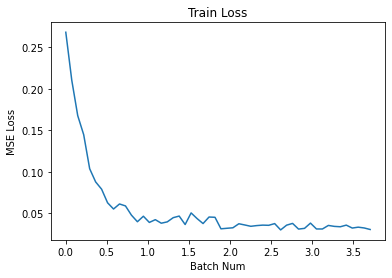

In [26]:
lossSmoothing = 20
lossIndex = [(i * lossSmoothing)/275 for i in range(len(lossList))]
plt.plot(lossIndex, lossList)
plt.xlabel("Batch Num")
plt.ylabel("MSE Loss")
plt.title("Train Loss")

In [27]:
np.array(validMetrics[0][0]).shape

(173,)

In [38]:
#validArr = np.array(validMetrics[4])
#print(validArr.shape)
validArr = np.array(validMetrics)
#validArr = validArr[5,:,:]
#np.corrcoef(test[1], test[2])

outDfList = []
iterList = []
corrList = []
#go through each validation step

for i in range(validArr.shape[0]): 
    print(i)
    subDf = pd.DataFrame(validArr[i].T)
    subDf.columns = ["loss", "pred", "true"]
    

    predCols = ["pred" + item for item in groundTruths]
    gtCols = ["gt" + item for item in groundTruths]
    
    
    subDf[predCols] = pd.DataFrame(subDf["pred"].tolist(), index=subDf.index)
    subDf[gtCols] = pd.DataFrame(subDf["true"].tolist(), index=subDf.index)
    
    corrScores = []
    for colName in groundTruths: 
        corr = np.corrcoef(subDf["pred" + colName], subDf["gt" + colName])[1, 0]
        corrScores.append(corr)
    corrList.append(corrScores)
    
corrDf = pd.DataFrame(corrList, columns=groundTruths)

#plt.plot(iterList, corrList)
#plt.xlabel("batch num")
#plt.ylabel("pearson correlation")
#plt.title("validation eval")


0
1
2
3
4


<ipython-input-38-3f433cc7889e>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  validArr = np.array(validMetrics)


In [39]:
validArr[1:,:,:].shape

(4, 3, 173)

In [42]:
corrDf

,Geography,Entities,Narrative,Overall
0,-0.149120,0.068737,-0.248528,0.035040
1,0.714452,0.795597,0.797646,0.841531
2,0.750122,0.827253,0.817953,0.868189
3,0.786643,0.842382,0.829971,0.886190
4,0.783473,0.844447,0.829451,0.886646


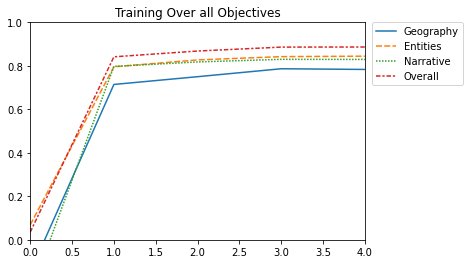

In [40]:
sns.lineplot(data=corrDf)
plt.title("Training Over all Objectives")
plt.ylim(0, 1)
plt.xlim(0, EPOCHS)
#Grabbed this line from: https://www.statology.org/seaborn-legend-outside/
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

Text(0, 0.5, 'prediction')

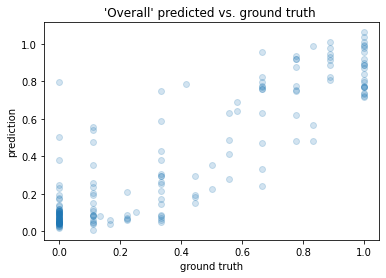

In [41]:
plt.scatter(subDf["gtOverall"], subDf["predOverall"], alpha = .2)
plt.title("'Overall' predicted vs. ground truth ")
plt.xlabel("ground truth")
plt.ylabel("prediction")

In [ ]:
print(x)
print(label)
print()

In [ ]:
loss_func(x, label)

In [ ]:
plt.plot(trainDf["testLoss"].dropna())

In [ ]:
valX

In [ ]:
vLabel

In [ ]:
x

In [ ]:
label